# Timeseries Feature Generation & Selection
In this notebook we show how one can create and select features specifically for time series modelling.  
There are some places in which you can explore alternative solutions, and try to find an even better solution yourself.  

The notebook contains the following parts:
 1. **Setup**: Here we setup and verify the environment (mainly data directory and imports)
 1. **Data load**: Now we load the data, and show some statistics
 1. **Feature generation**: Derive features to allow better models
 1. **Defining evaluation**: Define our objective/cost function, and train/validate/test sets.
 1. **Model tuning**: Determine a model which performs best given the features
 1. **Selecting features**: Choose other features, such that the model generalizes better
 1. **Final score on the test set**: After all our tuning, get the final score on the testset

---
## 1 - Setup

### Folders

Here we define the directory holding the dataset, this folder should contain the `soi.dat` and `recruit.dat` datasets:

In [1]:
datafolder = "data"

Determining wether the folder holds the expected data files:

In [2]:
import os
has_soi = sum([name.endswith("soi.dat") for name in os.listdir(datafolder)])
has_recruit = sum([name.endswith("recruit.dat") for name in os.listdir(datafolder)])

And telling you if the folder is correct:

In [3]:
if (has_soi and has_recruit):
    print 'You are ready to go'
else:
    print 'Your current directory is:'
    print os.getcwd()
    print 'And found the following files in the "{}" directory:'.format(datafolder)
    print os.listdir(datafolder)
    print ''
if not has_soi:
    print 'You are missing soi.dat'
if not has_recruit:
    print 'You are missing recruit.dat'
assert (has_soi and has_recruit)

You are ready to go


### Imports
We have placed all imports at the beginning to not clutter the other cells.
Any failed import means you probably aren't running in the correct kernel. 
Please verify you are using 'Python [conda env:meetup_ds_timeseris]', which can be created using `conda env create -f environment.yml`

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
#%load_ext autoreload
#%autoreload 1
#%aimport bdranalytics
import bdranalytics
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
from scipy.ndimage.interpolation import shift
import sklearn
from sklearn import linear_model, model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics.scorer import r2_scorer, mean_squared_error_scorer
import statsmodels
import statsmodels.tsa.api as sm
from bdranalytics.model_selection.growingwindow import GrowingWindow
from bdranalytics.pandaspipeline.transformers import PdFeatureChain, PdFeatureUnion, PdWindowTransformer, PdLagTransformer
from IPython.display import display
import IPython
print "IPython version: {}".format(IPython.__version__)
print "statsmodels: {}".format(statsmodels.__version__)
print "numpy: {}".format(np.__version__)
print "scipy: {}".format(sc.__version__)
print "sklearn: {}".format(sklearn.__version__)
print "pandas: {}".format(pd.__version__)

IPython version: 5.3.0
statsmodels: 0.8.0
numpy: 1.13.0
scipy: 0.19.0
sklearn: 0.18.1
pandas: 0.20.2


/Users/gerben/anaconda3/envs/meetup_ds_timeseries/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


---
## 2 - Data load

Here we load the two datasets, `soi.dat` and `recruit.dat`.
 - `soi.dat` holds the Southern Oscillation Index Data, which is is the difference in barometric pressure at sea level between Tahiti and Darwin. This is related to the El Nino / El Nina effect.
 - `recruit.dat` holds new fish recruitment

In [5]:
X_orig = pd.read_csv(os.path.join(datafolder, "soi.dat"), header=0, names=["soi"])
rng=pd.date_range('1/1/1866', periods=X_orig.size, freq='MS')
X_orig = X_orig.set_index(rng)
y_orig = pd.read_csv(os.path.join(datafolder, "recruit.dat"), header=0, names=["recruit"]).set_index(rng).iloc[:,0]

### Some information about the data set

To following cells show you some (basic) information about the dataset

In [6]:
print "The soi dataset is used as features, and is {} rows by {} columns".format(X_orig.shape[0], X_orig.shape[1])
print "The recruit dataset holds the target value, and is a series of {} rows".format(y_orig.shape[0])
print "The first few rows, combining the features with the target, looks as follows:"
print X_orig.join(y_orig).head()
print "Some quantile statistics about the range of values:"
print X_orig.join(y_orig).describe()

The soi dataset is used as features, and is 452 rows by 1 columns
The recruit dataset holds the target value, and is a series of 452 rows
The first few rows, combining the features with the target, looks as follows:
                       soi  recruit
1866-01-01 00:00:00  0.246    68.63
1866-02-01 00:00:00  0.311    68.63
1866-03-01 00:00:00  0.104    68.63
1866-04-01 00:00:00 -0.016    68.63
1866-05-01 00:00:00  0.235    68.63
Some quantile statistics about the range of values:
              soi     recruit
count  452.000000  452.000000
mean     0.079381   62.248695
std      0.382915   28.006504
min     -1.000000    1.720000
25%     -0.182750   39.597500
50%      0.115000   68.625000
75%      0.366000   86.860000
max      1.000000  100.000000


Let us now show how the timeseries look through time:

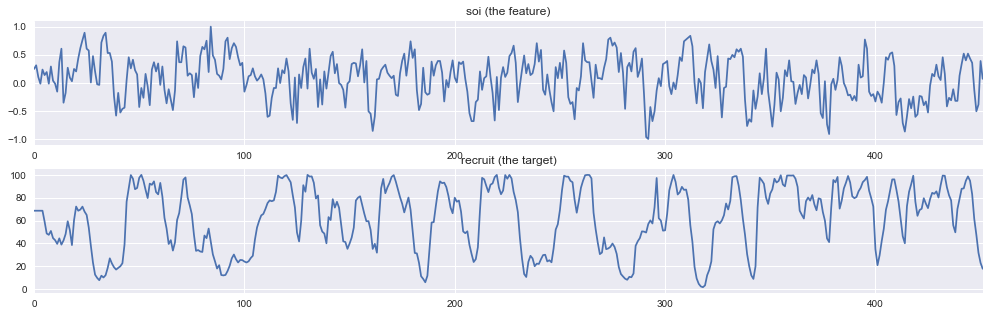

In [7]:
fig, ax = plt.subplots(figsize=(17, 5), ncols=1, nrows=2)
ax[0].set_title("soi (the feature)")
fig1 = sns.tsplot(X_orig.soi, ax=ax[0])
ax[1].set_title("recruit (the target)")
fig2 = sns.tsplot(y_orig, ax=ax[1])

### Defining the target variable
Instead of predicting the *current* recruit, we will attempt to predict the *next* recruit. Therefore we shift the `y_orig` by `-1` to get the value of 1 time ahead.

Note that this will result in a NaN value on the last index, which we therefore remove.

In [8]:
y = y_orig.shift(-1).dropna() # the next recruit

### Defining the base features
Currently we only have the `soi` feature as dataset. As we also know the *current* `soi` value, we add that to X.

As we have one less value of `y` (we don't know the next value at the last row), we subselect only the `X` features for which we have a predictable future `recruit` value.

In [9]:
X = pd.concat([X_orig,  # the original features: the current soi
               y_orig.to_frame() # the current recruit
              ], axis=1, join_axes=[X_orig.index]).loc[y.index,:]

---
## 3 - Feature generation

Now we have a set of features `X`, and a target sequence `y`.
We will now enrich the dataset by with additional features to allow better predictions on `y`. The final set of features will be assigned to the variable `X`.

This uses a sklearn transformer `PdLagTransformer` which will be explained in the next section

### Add derived features
Given this first version of X, we can add new features. In general, you can add transformations of the colums, using for example :
  * http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html
  * http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html
  
To simplify the application of such transformations, we have created a few helper transformers, which work nicely with sklearn's pipelines:
  * `PdLagTransformer(lag)`: This transforms the columns by adding a 'lagged' version. The constructor argument defines the lag to apply. This uses `pandas.DataFrame.shift` to shift the columns. The returned transformation however, also has modified column names. A column `soi`, if shifted `1`, will be transformed into a column named `soi_lag1`.
  * `PdWindowTransformer(function, window)`: This transforms the column using a `rolling`. All constructor arguments are passed through to `pandas.DataFrame.rolling`. In general, one usually provides a `function`, and a `window`. The `window` defines the number of previous values to take, and then applies the provided `function` to those values.

The sklearn `FeatureUnion` and `Pipeline` unfortunately drop the column names when pandas dataframes are passed to them. Therefore we've also made pandas versions:
 * `PdFeatureUnion`: Same as sklearn's `FeatureUnion`, but propagates column names of the contained transformers.  
 The sklearn's `FeatureUnion` always returns a `numpy` `array`, without column labels.  
 Our `PdFeatureUnion` always returns a `pandas` `DataFrame`, propagating the column labels of the contained transformers.  
 If the applied transformer does not return a `pandas` `DataFrame` (thus no column labels), column labels are generated using the format `transformername-index`. For example, `PdFeatureUnion([(feat,MyTransformer())])` will generate column labels like `feat-1` and `feat-2` if the `MyTransformer`'s `transform()` function returns a numpy array.
 * `PdFeatureChain`: Similar to sklearn's `Pipeline`, applies subsequent transformers to each other result.  
 Thus `PdFeatureChain( [ ('f1', MyFirstTransformer()), ('f2', MySecondTransformer()) ] )` will apply `MySecondTransformer.transform` on the result of `MyFirstTransformer.transform`.

### Recommended solution for feature generation: create lagged windows
One way to create a lot of features, is to first create different windows, and then apply different lags to those windows. As we already have lags of single moments, and windows ending at the current time, we here only add lagged windows. To prevent too many overlapping windows, we use a stepsize of the lag which is equal to the window size.

In [10]:
window_transformers = PdFeatureUnion([
        ('window{}'.format(window), PdWindowTransformer(lambda x: x.mean(), window=window)) for window in range(1, 12)
    ])
lag_transformers = PdFeatureUnion([
        ('lag{}'.format(lag), PdLagTransformer(lag)) for lag in range(20)])

new_features = [
    ('chain{}'.format(window),
     PdFeatureChain([
        ('window{}'.format(window), PdWindowTransformer(lambda x: x.mean(), window=window)),
        ('lags', PdFeatureUnion([('lag{}'.format(lag), PdLagTransformer(lag)) for lag in range(window, 20, window)]))
        ])
     )
     for window in range(2, 12, 2)]
combined_features = PdFeatureUnion(
    [('window{}'.format(window), PdWindowTransformer(lambda x: x.mean(), window=window)) for window in range(1,12)]
    + 
    [('lag{}'.format(lag), PdLagTransformer(lag)) for lag in range(20)]
    + new_features
    )

### Selecting usefull rows
As the previous examples show, applying lags and windows result in `NaN` values for the first few rows. Let us remove those to only have complete rows.

In [11]:
X = combined_features.fit_transform(X).dropna()
y = y[X.index] # because of dropped rows in X, need to also select corresponding remaining rows from y

> ps. You might think, are we allowed to do `fit_transform` on the **complete** dataset?! Yes we are, because we don't have information leakage, because: 
 * the feature only takes into acount previous rows (rows with older timestamps)
 * and our cross validation, explained below, only tests on future rows (rows with more recent timestamps).

---
## 4 - Defining the evaluation
### Defining the test method of the model
With a dataset of features (X), and a target variable (y), let's see how well we can predict the recruit.  
First we define the evaluation metric, and some helper functions to easily get results for cross validation:
 * `model_score` is the function we use to determine the cost
 * `model_scorer` is the same function, wrapped by sklearn to be able to be used by model selectors.
 * `cross_val` determines the cross validated test score, in which the folds are created specifically for timeseries. The data is divided into `cv_count+` splits.   
 The first fold uses split 1 as train set, and split 2 as validation set.  
 The second fold uses split 1 and 2 as train set, and split 3 as validation set.
 The `cv_count`th fold uses split 1 up till `cv_count` as train set, and split `cv_count+1` as validation set.
 * `cross_val_train` determines the cross validated train score. Thus similar to `cross_val`, but returns the train error instead of the validation error.

In [12]:
model_score = mean_squared_error
model_scorer = make_scorer(mean_squared_error, greater_is_better=False)

def cross_val(estimator, X, y, scorer = model_scorer, cv_count=10):
    return model_selection.cross_val_score(estimator, X, y.to_frame(), 
                                           scoring = scorer,
                                           cv=GrowingWindow(cv_count))

## for different folds, trains the model, en returns the error on the **train** sets.
def cross_val_train(estimator, X, y, scorer = model_scorer, cv_count=10):
    return [scorer(estimator.fit(X.iloc[train,:], y.iloc[train]),
                   X.iloc[train,:],
                   y.iloc[train])
             for train, test in GrowingWindow(cv_count).split(X)]

### Selecting a hold out set

First we extract a train & test set from the full dataset

In [13]:
i_train, i_test = list(itertools.islice(GrowingWindow(8).split(X), 6, 7))[0]
X_train = X.iloc[i_train,:]
y_train = y[i_train]

X_test = X.iloc[i_test,:]
y_test = y[i_test]
print "Train datasize dimensions = {}, Test datasets dimensions= {} ".format(X_train.shape, X_test.shape)

Train datasize dimensions = (332, 100), Test datasets dimensions= (48, 100) 


In [14]:
print "The names of the available columns:"
display(X_train.columns)
print "The first few training rows (and only a few columns), including the target variable {}".format(y_train.name)
display(y_train.to_frame().join(X_train).iloc[:,0:6].head())

The names of the available columns:


Index([u'soi_window1', u'recruit_window1', u'soi_window2', u'recruit_window2',
       u'soi_window3', u'recruit_window3', u'soi_window4', u'recruit_window4',
       u'soi_window5', u'recruit_window5', u'soi_window6', u'recruit_window6',
       u'soi_window7', u'recruit_window7', u'soi_window8', u'recruit_window8',
       u'soi_window9', u'recruit_window9', u'soi_window10',
       u'recruit_window10', u'soi_window11', u'recruit_window11', u'soi_lag0',
       u'recruit_lag0', u'soi_lag1', u'recruit_lag1', u'soi_lag2',
       u'recruit_lag2', u'soi_lag3', u'recruit_lag3', u'soi_lag4',
       u'recruit_lag4', u'soi_lag5', u'recruit_lag5', u'soi_lag6',
       u'recruit_lag6', u'soi_lag7', u'recruit_lag7', u'soi_lag8',
       u'recruit_lag8', u'soi_lag9', u'recruit_lag9', u'soi_lag10',
       u'recruit_lag10', u'soi_lag11', u'recruit_lag11', u'soi_lag12',
       u'recruit_lag12', u'soi_lag13', u'recruit_lag13', u'soi_lag14',
       u'recruit_lag14', u'soi_lag15', u'recruit_lag15', u'soi_lag1

The first few training rows (and only a few columns), including the target variable recruit


,recruit,soi_window1,recruit_window1,soi_window2,recruit_window2,soi_window3
1867-12-01 00:00:00,67.87000,0.760,72.20000,0.6885,70.915000,0.603000
1868-01-01 00:00:00,64.91001,0.891,67.87000,0.8255,70.035000,0.756000
1868-02-01 00:00:00,53.85000,0.607,64.91001,0.7490,66.390005,0.752667
1868-03-01 00:00:00,37.96000,0.574,53.85000,0.5905,59.380005,0.690667
1868-04-01 00:00:00,23.23000,0.005,37.96000,0.2895,45.905000,0.395333


Note that `_window1` is actually just the value. Thus `soi_window1` is just the `soi` feature.  
Thus `recruit_lag1_window1` is the target `recruit`, one timestep in history.

## 5 - Model tuning
With the evaluation functions defined, we can start to create a predictive model

### First naive model
Here we create a first model, a simple linear regression.

In [15]:
linear_regression = Pipeline([
        ("lm", linear_model.LinearRegression())
    ])

#### The quality of our first naive model:

For reference, predicting y with the original features (thus only just the soi):

In [16]:
print "num features:{}".format(X_orig.shape[1])
print "Scores (higher is better);"
print "cv train:\t{}".format(np.mean(cross_val_train(linear_regression, X_orig.loc[X_train.index,:], y_train, cv_count=10)))
print "cv test:\t{}".format(np.mean(cross_val(linear_regression, X_orig.loc[X_train.index,:], y_train, cv_count=10)))

num features:1
Scores (higher is better);
cv train:	-872.114123517
cv test:	-911.120327024


Probably you do much better with your new set of features.

In [17]:
print "num features:{}".format(X.shape[1])
print "Scores (higher is better);"
print "cv train:\t{}".format(np.mean(cross_val_train(linear_regression, X, y, cv_count=10)))
print "cv test:\t{}".format(np.mean(cross_val(linear_regression, X, y, cv_count=10)))

num features:100
Scores (higher is better);
cv train:	-20.4075471062
cv test:	-141.198894829


### Choosing a different model
Feel free to select a different model, and see if you can increase the performance

In [18]:
alternative = Pipeline([
        ("ridge", Ridge(alpha=1.0))
    ])
print "num features:\t{}".format(X.shape[1])
print "Scores (higher is better);"
print "cv train:\t{}".format(np.mean(cross_val_train(alternative, X_train, y_train, cv_count=10)))
print "cv test:\t{}".format(np.mean(cross_val(alternative, X_train, y_train, cv_count=10)))

num features:	100
Scores (higher is better);
cv train:	-17.8307653117
cv test:	-63.3487305462


## Model tuning
### Recommended solution for model tuning: grid search cv on meta params

Most models need some meta parameter tuning, so let us also do that:

In [19]:
param_grid={'alpha':np.power(1.5, range(-8,4))}
display(param_grid)
ridge_cv = GridSearchCV(estimator = Ridge(),
                       param_grid=param_grid,
                       scoring=model_scorer,
                       n_jobs=1,
                       cv=GrowingWindow(4), # Usually useful to select a slightly different cv set
                       verbose=1).fit(X_train, y_train)

{'alpha': array([ 0.03901844,  0.05852766,  0.0877915 ,  0.13168724,  0.19753086,
         0.2962963 ,  0.44444444,  0.66666667,  1.        ,  1.5       ,
         2.25      ,  3.375     ])}

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.4s finished


This resulted in the following best meta parameters:

In [20]:
print "params:\t\t{}".format(ridge_cv.best_params_)
print "num features:\t{}".format(X.shape[1])
print "Scores (higher is better);"
print "cv train:\t{}".format(np.mean(cross_val_train(ridge_cv.best_estimator_, X_train, y_train, cv_count=10)))
print "cv test:\t{}".format(np.mean(cross_val(ridge_cv.best_estimator_, X_train, y_train, cv_count=10)))

params:		{'alpha': 2.25}
num features:	100
Scores (higher is better);
cv train:	-19.8757143839
cv test:	-75.2816737849


In [21]:
model_best = Ridge(**(ridge_cv.best_params_))

---
## 6 - Selecting features
Not all features are actually equally usefull. With too many available features, most models will have problems distinguishing noise from signal. One way is to use regularization (as used above), the other is to actually remove useless features.

### (partial) Autocorrelation
One classic way to determine usefull features is by looking at the autocorrelation, and partial autocorrelation.  
The regular autocorrelation shows the correlation of the target variable `recruit` with the lagged versions. Thus this is done by correlating the `recruit` with **just** the 1 lagged version of `recruit`, and then repeated for different lags.  
However, if lag 1 correlates, lag 2 will also correlate, because lag 2 is the 1 lagged version of lag 1.  
Therefore the partial autocorrelation plot is more usefull, as it shows the correlation, corrected for the correlation with the other lags. It can be made by applying a linear regression of the target `recruit` with **all** lagged versions in 1 model, such that the individual coefficients indicate the individual marginal effect.

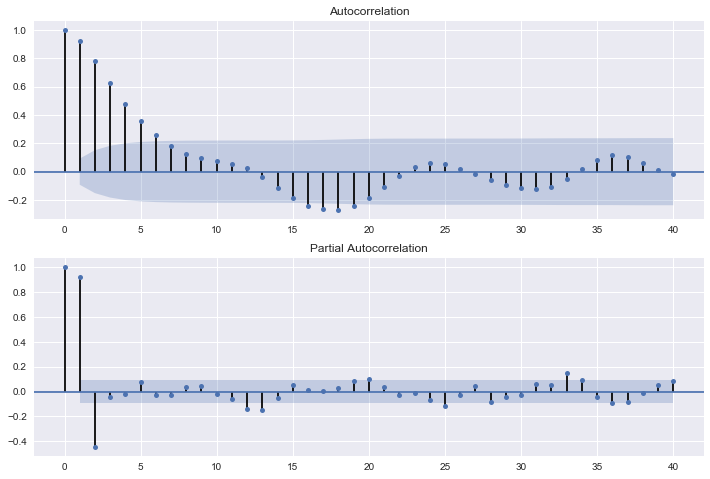

In [22]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.plot_acf(y_orig.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.plot_pacf(y_orig.squeeze(), lags=40, ax=ax2)

This shows that mainly the first 2 lags of `recruit` are useful, the others are just noise. (The first one at `x==0` reflects the correlation of `recruit` with itself)

### Recommended solution for feature selection: Recursive feature elimination

The recommended solution is to iteratively remove features, a few at a time, and take the set which works best on a validation set.

First we show how `RFE` in general works:

In [23]:
rfe = RFECV(model_best, step=5, scoring = model_scorer, cv=GrowingWindow(6))
print "Scores (higher is better) (not this selects features per fold);"
print "cv train:\t{}".format(np.mean(cross_val_train(rfe, X_train, y_train, cv_count=10)))
print "cv test:\t{}".format(np.mean(cross_val(rfe, X_train, y_train, cv_count=10)))

Scores (higher is better) (not this selects features per fold);
cv train:	-76.7926303336


/Users/gerben/anaconda3/envs/meetup_ds_timeseries/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


cv test:	-117.498546997


First we determine a fit, to get the order in which features are removed.  
In the current setup, the model is first fitted using all features. The 5 least important features are removed, and the model is refit. This is repeated until only 10 features remain. This gives an ordering of all features (the order they were removed). 

In [24]:
rfe_fit = rfe.fit(X_train, y_train)
print rfe_fit.n_features_
print "As an example, the last remaining features were:"
X_train.loc[:, rfe_fit.ranking_<=1].head()

50
As an example, the last remaining features were:


,soi_window1,recruit_window1,soi_window2,soi_window3,soi_window4,soi_window5,soi_window6,soi_window7,soi_window8,soi_window9,...,soi_window2_lag18,soi_window4_lag4,soi_window4_lag8,soi_window4_lag16,soi_window6_lag6,soi_window6_lag12,soi_window6_lag18,soi_window8_lag8,soi_window8_lag16,soi_window10_lag10
1867-12-01 00:00:00,0.760,72.20000,0.6885,0.603000,0.50275,0.4514,0.380667,0.339571,0.330625,0.273889,...,0.1860,0.15850,0.1095,0.13675,0.133167,0.054833,0.169500,0.074000,0.149000,0.1674
1868-01-01 00:00:00,0.891,67.87000,0.8255,0.756000,0.67500,0.5804,0.524667,0.453571,0.408500,0.392889,...,0.1640,0.14200,0.0850,0.15050,0.076667,0.084000,0.160333,0.071250,0.154500,0.1084
1868-02-01 00:00:00,0.607,64.91001,0.7490,0.752667,0.71875,0.6614,0.584833,0.536429,0.472750,0.430556,...,0.0875,0.22675,-0.0435,0.12575,0.016500,0.187833,0.105833,0.078125,0.120375,0.0767
1868-03-01 00:00:00,0.574,53.85000,0.5905,0.690667,0.70800,0.6898,0.646833,0.583286,0.541125,0.484000,...,0.1370,0.37425,0.0520,0.07400,0.109333,0.080333,0.136833,0.083500,0.105375,0.0844
1868-04-01 00:00:00,0.005,37.96000,0.2895,0.395333,0.51925,0.5674,0.575667,0.555143,0.511000,0.481556,...,0.1640,0.50275,0.1585,0.03850,0.211333,0.044000,0.145833,0.134000,0.087625,0.0953


Now, per step, we determine the cross val score using the features that were still remaining at that step. This gives a good evaluation of those features, of which we can then select the best:

In [25]:
rfe_all = [np.mean(cross_val(
                                model_best, 
                                X_train.loc[:, rfe_fit.ranking_<=i], 
                                y_train, 
                                cv_count=3))
     for i in range(1, max(rfe_fit.ranking_))]
best_index = np.array(rfe_all).argsort()[::-1][0]

We now define two variables to indicate the selected features:
 * `column_mask` : an indexer to be used on the pandas dataframe to select columns
 * `X_sub_train` : The full train dataset (`X_train`), but only the selected features
 * `X_sub_test` : The train dataset (`X_test`), but only the selected features

In [26]:
column_mask = rfe_fit.ranking_<=(best_index+1)
X_sub_train = X_train.loc[:, column_mask]
X_sub_test = X_test.loc[:, column_mask]
print 'Best index          = {}'.format(best_index)
print 'Best nr of features = {}'.format(sum(column_mask))
print 'Which gives score   = {}'.format(rfe_all[best_index])

print 'Column names        = {}'.format(X_train.columns[column_mask].values)
print "Scores (higher is better);"
print "cv train:\t{}".format(np.mean(cross_val_train(model_best, X_sub_train, y_train, cv_count=10)))
print "cv test:\t{}".format(np.mean(cross_val(model_best, X_sub_train, y_train, cv_count=10)))

Best index          = 1
Best nr of features = 55
Which gives score   = -53.3579157082
Column names        = ['soi_window1' 'recruit_window1' 'soi_window2' 'recruit_window2'
 'soi_window3' 'soi_window4' 'soi_window5' 'soi_window6' 'soi_window7'
 'soi_window8' 'soi_window9' 'soi_window10' 'soi_window11' 'soi_lag0'
 'recruit_lag0' 'soi_lag1' 'recruit_lag1' 'soi_lag2' 'soi_lag3' 'soi_lag4'
 'soi_lag5' 'soi_lag6' 'recruit_lag6' 'soi_lag7' 'soi_lag8' 'soi_lag9'
 'soi_lag10' 'soi_lag11' 'soi_lag12' 'soi_lag13' 'soi_lag14' 'soi_lag15'
 'soi_lag16' 'soi_lag17' 'soi_lag18' 'soi_lag19' 'soi_window2_lag2'
 'soi_window2_lag4' 'recruit_window2_lag4' 'soi_window2_lag6'
 'soi_window2_lag8' 'soi_window2_lag10' 'soi_window2_lag12'
 'soi_window2_lag14' 'soi_window2_lag16' 'soi_window2_lag18'
 'soi_window4_lag4' 'soi_window4_lag8' 'soi_window4_lag16'
 'soi_window6_lag6' 'soi_window6_lag12' 'soi_window6_lag18'
 'soi_window8_lag8' 'soi_window8_lag16' 'soi_window10_lag10']
Scores (higher is better);
cv train

---
## 7 - Final score on the test set
When you are done tuning and selection, it is time to evaluate the performance on a hold out set.

To easily print the same measurements for different configurations, we define a helper function here:
> Here we multiply the `model_score` by -1 to get the score comparable to the previous cross validations  
> Note that the holdout test score will very likely be worse than the cv test score. One reason is that all meta params were selected to optimize that test score.

In [27]:
def final_describe(model, train, test):
    """Evaluates a model on the final test set. For comparison, also (cv) measurements are given about the train set.
    model is the pandas pipeline that is evaluated
    train is the train dataset (with more/less features)
    test is the test dataset (with the same features as x_train)
    """
    # first some cross validation measurements
    print "cross validated (within train set)"
    print "cv train:\t{}".format(np.mean(cross_val_train(model, train, y_train, cv_count=10)))
    print "cv test:\t{}".format(np.mean(cross_val(model, train, y_train, cv_count=10)))
    # first fit the model on the FULL train set
    fit = model.fit(train, y_train)
    test_predictions = fit.predict(test)
    print 'full train:\t{}'.format(-model_score(y_train, fit.predict(train)))
    print "After fitting on full train set, evaluating on holdout set:"
    print 'Holdout test:\t{}'.format(-model_score(y_test, test_predictions))
    print 'Holdout r2:\t{}'.format(r2_score(y_test, test_predictions))

# Conclusion

### Best model on selected features

In [28]:
model_best

Ridge(alpha=2.25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [29]:
final_describe(model_best, X_sub_train, X_sub_test)

cross validated (within train set)
cv train:	-22.0732510886
cv test:	-50.7587373495
full train:	-36.2309930992
After fitting on full train set, evaluating on holdout set:
Holdout test:	-82.5438246846
Holdout r2:	0.782857807464


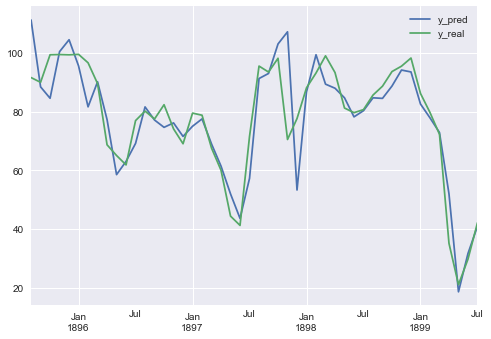

In [30]:
fit = model_best.fit(X_sub_train, y_train)
test_predictions = fit.predict(X_sub_test)
result = pd.DataFrame({"y_pred":test_predictions, "y_real":y_test})
result.plot()

### Best model on all features

In [31]:
final_describe(model_best, X_train, X_test)

cross validated (within train set)
cv train:	-19.8757143839
cv test:	-75.2816737849
full train:	-34.3089012626
After fitting on full train set, evaluating on holdout set:
Holdout test:	-85.3652616689
Holdout r2:	0.775435653049


### Alternative model on all features

In [32]:
final_describe(alternative, X_train, X_test)

cross validated (within train set)
cv train:	-17.8307653117
cv test:	-63.3487305462
full train:	-33.9802811859
After fitting on full train set, evaluating on holdout set:
Holdout test:	-87.9531175786
Holdout r2:	0.76862796382


### Initial (linear) model on all features

In [33]:
final_describe(linear_regression, X_train, X_test)

cross validated (within train set)
cv train:	-15.9144580059
cv test:	-215.396484184
full train:	-33.7352570243
After fitting on full train set, evaluating on holdout set:
Holdout test:	-91.62601354
Holdout r2:	0.758965936587
